In [20]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/regression/car-reg-data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9055 entries, 0 to 9054
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   make           8164 non-null   object 
 1   transmission   8106 non-null   object 
 2   state          8152 non-null   object 
 3   condition      8173 non-null   float64
 4   odometer       8178 non-null   float64
 5   auction_value  8107 non-null   float64
 6   selling_price  9055 non-null   float64
dtypes: float64(4), object(3)
memory usage: 495.3+ KB


In [21]:
from sklearn.model_selection import train_test_split
features = [x for x in df.columns if x != 'selling_price']

X = df[features]
y = df['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

print(f'Records in training data: {X_train.shape[0]:,}')
print(f'Records in test data: {X_test.shape[0]:,}')
print('\nFeatures:')
print(*X_train.columns, sep='\n')

Records in training data: 7,244
Records in test data: 1,811

Features:
make
transmission
state
condition
odometer
auction_value


### Question 1: Split the features into two lists, one for the numerical features and another for the categorical features.

In [22]:
df.head()

,make,transmission,state,condition,odometer,auction_value,selling_price
0,nissan,automatic,md,4.8,NaN,14350.0,13600.0
1,ford,automatic,mo,3.7,29398.0,17600.0,17100.0
2,ford,automatic,fl,3.2,32180.0,19100.0,17600.0
3,nissan,automatic,ca,NaN,30798.0,11950.0,10700.0
4,ford,automatic,nj,2.8,29526.0,28000.0,26100.0


#### Here we can see that the numerical features are condition, odometer, auction_value, and selling_price is the label

In [23]:
cat_vars = ['make', 'transmission', 'state']
num_vars = ['odometer', 'auction_value', 'condition']

### Question 2: Using the numerical variables, create a pipeline that replaces the missing values with the median and then standardizes the values using a standard scaler.

In [24]:
# for making pipleines, we must first import the required libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [25]:
num_pipeline = Pipeline([('impute_missing', SimpleImputer(strategy='median')),
                           ('standardize_num', StandardScaler())
                        ])

### Question 3: Using the categorical variables, create a pipeline that replaces the missing values with the most frequent and then use one-hot encoding to convert the data to numerical arrays.

In [26]:
cat_pipeline = Pipeline([('impute_missing_cats', SimpleImputer(strategy='most_frequent')),
                          ('create_dummies_cats', OneHotEncoder(handle_unknown='ignore', drop='first'))])

### Question 4: Combine the numerical and categorical pipelines into one data processing pipeline.

In [27]:
processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, num_vars),
                                                      ('create_dummies', cat_pipeline, cat_vars)])

print(processing_pipeline)

ColumnTransformer(transformers=[('proc_numeric',
                                 Pipeline(steps=[('impute_missing',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardize_num',
                                                  StandardScaler())]),
                                 ['odometer', 'auction_value', 'condition']),
                                ('create_dummies',
                                 Pipeline(steps=[('impute_missing_cats',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('create_dummies_cats',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['make', 'transmission', 'state'])])


### Question 5: Add a linear regression model to the pipeline.

In [28]:
from sklearn.linear_model import LinearRegression

modeling_pipeline = Pipeline([('data_processing', processing_pipeline), 
                              ('lm', LinearRegression())
                             ])
modeling_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['odometer', 'auction_value',
                                                   'condition']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['make', 'transmission',
                                                   'state'])])),
                ('lm', LinearRegression())])

In [29]:
price_predictions = modeling_pipeline.predict(X_test)

In [30]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, price_predictions)
r2

0.8838276360514414

### Question 6: Create a plot(s) of the residuals. Do you have any concerns about patterns in the residuals that the model is neglecting to pick-up?

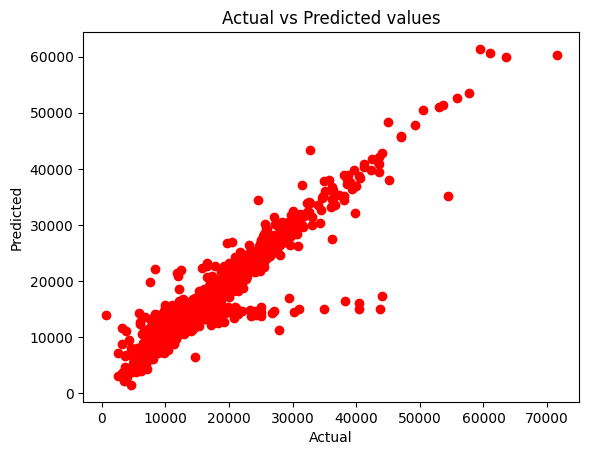

In [31]:
import matplotlib.pyplot as plt

plt.plot(y_test, price_predictions, 'ro')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title("Actual vs Predicted values")
plt.show()

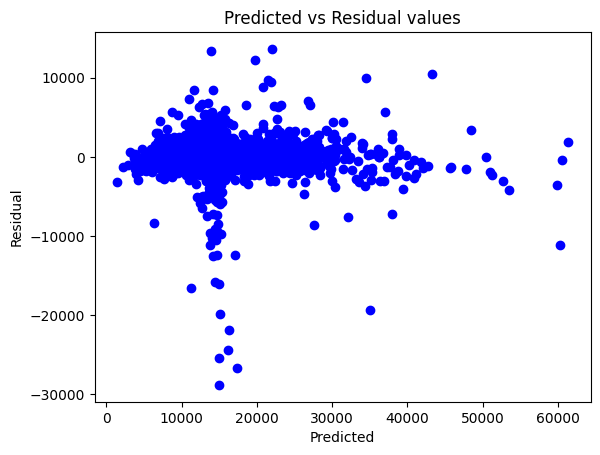

In [32]:
plt.plot(price_predictions, price_predictions - y_test, 'bo')
plt.ylabel('Residual')
plt.xlabel('Predicted')
plt.title("Predicted vs Residual values")
plt.show()

#### Many areas of the graph follow the ideal layout, where they are close to 0, and there is a bit of noise. However, we can observe that in one certain range of predictions (between around 10,000 and 20,000), the errors are much more. It is strange that the errors are concentrated mainly in this range

### Question 7: Modify the pipeline to use a ridge regression model with an alpha value of 100. How does this change the R2?

In [33]:
from sklearn.linear_model import Ridge

modeling_pipeline = Pipeline([('data_processing', processing_pipeline), 
                              ('lm', Ridge(alpha = 100))
                             ])
modeling_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['odometer', 'auction_value',
                                                   'condition']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['make', 'transmission',
                                                   'state'])])),
                ('lm', Ridge(alpha=100))])

In [34]:
price_predictions_ridge = modeling_pipeline.predict(X_test)
r2_ridge = r2_score(y_test, price_predictions_ridge)
r2_ridge

0.8825299835291487

#### We can see the R2 value here is slightly lower than what we got above. This may be because the alpha value is too big, we may have missed the local minima, and thus have not efficiently minimised the cost function.